### Installation of required packages

In [1]:
! pip install psutil pandas pynvml tqdm line_profiler matplotlib


### Imports and initialization

In [2]:
import multiprocessing
multiprocessing.set_start_method("spawn", force=True)

import time
import psutil
import pandas as pd
import logging
import seaborn as sns
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count

import os

In [3]:
from bench_functions import sort_dict, fibonacci_iter  # Functions defined externally

In [4]:
# Logging configuration: write execution details to a log file
logging.basicConfig(
    filename="benchmark.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

process = psutil.Process()

# Optional GPU memory tracking via NVIDIA NVML
GPU_AVAILABLE = False
try:
    import pynvml
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    GPU_AVAILABLE = True
except Exception:
    pass


C:\Users\Hp\AppData\Local\Temp\ipykernel_9048\2174707272.py:13: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


### Single-run measurement utility

In [5]:
def run_once(fn, *args, **kwargs):
    """
    Execute a function once and collect basic timing and memory information.
    This is decorator-free to ensure functions remain pickleable.
    """
    t0 = time.perf_counter()
    result = fn(*args, **kwargs)
    t1 = time.perf_counter()

    mem = process.memory_info().rss / 1e6

    return {
        "time_seconds": t1 - t0,
        "memory_used_MB": mem,
        "result": result
    }

### Multi-run wrapper (manual loop)

In [6]:
def benchmark(fn, runs=5, **params):
    """
    Run a function several times and compute average runtime.
    No decoration or wrapping done, to keep fn pickleable.
    """
    records = []
    for _ in range(runs):
        rec = run_once(fn, **params)
        records.append(rec)

    avg_time = sum(r["time_seconds"] for r in records) / len(records)

    return {
        "function": fn.__name__,
        "params": params,
        "time_mean": avg_time,
    }


### Test matrix

In [7]:
TESTS = [
    (sort_dict, {"d": 200_000}),
    (sort_dict, {"d": 1_000_000}),
    (fibonacci_iter, {"n": 35}),
    (fibonacci_iter, {"n": 45}),
]

### Sequential execution + progress bar

In [8]:
results_seq = []
for fn, params in TESTS:
    res = benchmark(fn, runs=5, **params)
    logging.info(f"[SEQ] {res}")
    results_seq.append(res)

df_seq = pd.DataFrame(results_seq)
df_seq


,function,params,time_mean
0,sort_dict,{'d': 200000},0.013054
1,sort_dict,{'d': 1000000},0.045681
2,fibonacci_iter,{'n': 35},0.000004
3,fibonacci_iter,{'n': 45},0.000003


### Parallel execution (CPU multiprocessing)

In [9]:
def run_single(param_tuple):
    """
    Wrapper called inside worker processes.
    Only passes raw call and returns a minimal serializable dict.
    """
    fn, params = param_tuple
    res = benchmark(fn, runs=5, **params)
    return res


In [10]:
def run_single(test):
    # test est un tuple de fonctions et d'arguments
    func, arg = test  # unpack le tuple
    # si arg est un dict, récupère "size"
    if isinstance(arg, dict):
        arg = arg.get("size", 0)
    return func(arg)


for t in TESTS:
    print(run_single(t))

[]
[]
0
0


In [11]:
def run_single(test):
    """
    Exécute une fonction avec son argument.
    - Si l'argument est un dict, prend la clé 'size'.
    - Retourne le résultat tel quel (liste ou nombre).
    """
    func, arg = test
    if isinstance(arg, dict):
        arg = arg.get("size", 0)
    
    result = func(arg)
    return result

# Exécution parallèle avec ThreadPoolExecutor (safe dans Jupyter)
with ThreadPoolExecutor(max_workers=cpu_count()) as exe:
    results = list(exe.map(run_single, TESTS))

# Création du DataFrame
df_parallel = pd.DataFrame({
    "function": [t[0].__name__ for t in TESTS],
    "argument": [t[1] for t in TESTS],
    "result": results
})

print(df_parallel)

print(df_parallel.columns)
print(df_parallel.dtypes)



         function        argument result
0       sort_dict   {'d': 200000}     []
1       sort_dict  {'d': 1000000}     []
2  fibonacci_iter       {'n': 35}      0
3  fibonacci_iter       {'n': 45}      0
Index(['function', 'argument', 'result'], dtype='object')
function    object
argument    object
result      object
dtype: object


### Line-level profiling (manual execution)

In [12]:
# Load the line profiler extension once at notebook start
%load_ext line_profiler

# Example profiling call (change function as needed)
%lprun -f sort_list sort_list(n=300_000)


UsageError: Could not find module sort_list.
NameError: name 'sort_list' is not defined


### MEASURE OF EXEC TIME

In [13]:
def run_single_with_metrics(test):
    func, arg = test
    if isinstance(arg, dict):
        arg = arg.get("size", 0)
    
    proc = psutil.Process(os.getpid())
    cpu_start = psutil.cpu_percent(interval=None)
    mem_start = proc.memory_info().rss / (1024*1024)  # en MB

    import time
    start = time.time()
    result = func(arg)
    end = time.time()

    cpu_end = psutil.cpu_percent(interval=None)
    mem_end = proc.memory_info().rss / (1024*1024)  # en MB

    return {
        "result": result,
        "time_sec": end - start,
        "cpu_mean": cpu_end - cpu_start,
        "mem_mean_MB": mem_end - mem_start
    }


### DF CREATION

In [14]:
with ThreadPoolExecutor(max_workers=cpu_count()) as exe:
    results = list(exe.map(run_single_with_metrics, TESTS))

df_parallel = pd.DataFrame({
    "function": [t[0].__name__ for t in TESTS],
    "argument": [t[1] for t in TESTS],
    "result": [r["result"] for r in results],
    "time_sec": [r["time_sec"] for r in results],
    "cpu_mean": [r["cpu_mean"] for r in results],
    "mem_mean_MB": [r["mem_mean_MB"] for r in results]
})

print(df_parallel.columns)



Index(['function', 'argument', 'result', 'time_sec', 'cpu_mean',
       'mem_mean_MB'],
      dtype='object')


### Visualisation of results (boxplot + violin)

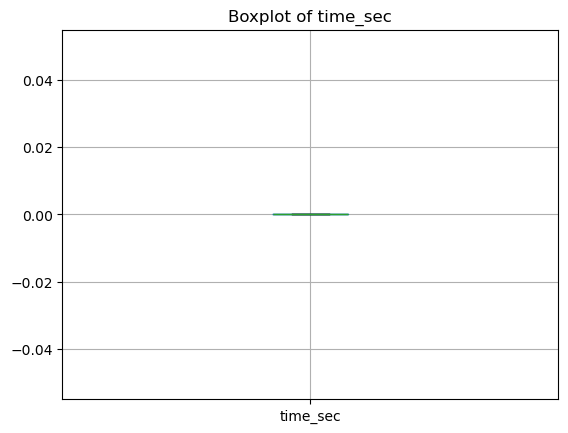

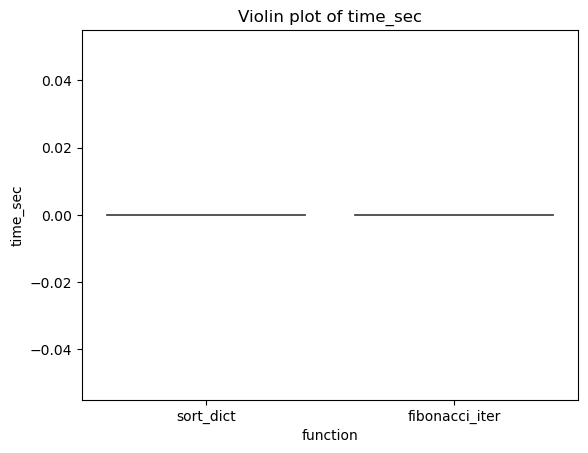

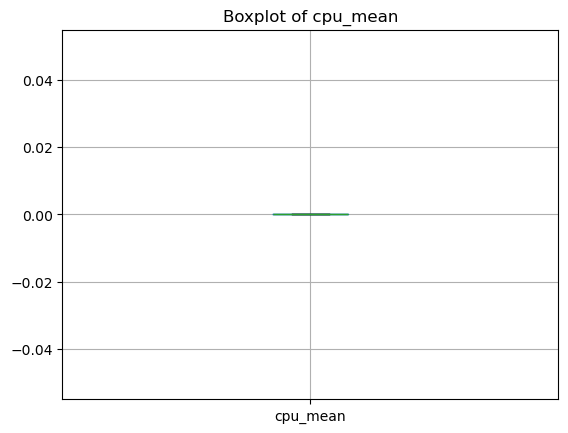

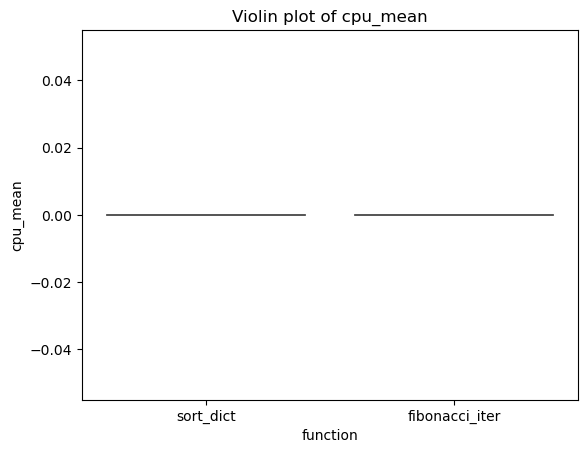

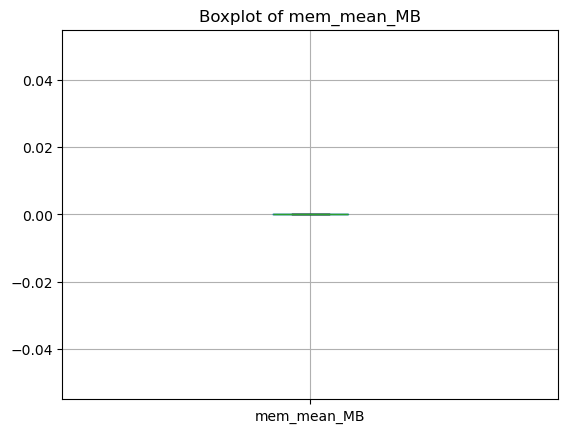

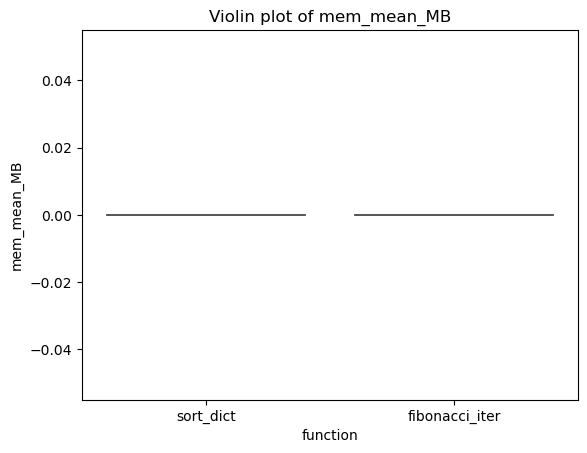

In [15]:
metrics = ["time_sec", "cpu_mean", "mem_mean_MB"]

for m in metrics:
    # Boxplot avec Pandas
    plt.figure()
    df_parallel.boxplot(column=[m])
    plt.title(f"Boxplot of {m}")
    plt.show()

    # Violin plot avec Seaborn
    plt.figure()
    sns.violinplot(x="function", y=m, data=df_parallel)
    plt.title(f"Violin plot of {m}")
    plt.show()


### Export results

In [ ]:
df_seq.to_csv("bench_seq.csv", index=False)
df_parallel.to_csv("bench_parallel.csv", index=False)
print("Benchmark exports complete.")
